In [5]:
import numpy as np
import scipy.optimize as SciOpt
import scipy.stats as SciStat
import scipy.special as SciSpec
from numpy import random as rnd
from numpy import linalg as LA
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [6]:
#First we need to import data
#I am using pathlib to make path string
#platform indepenedent
from pathlib import Path
#insert your path here
Folder = Path()
File1 = Folder / "D1.txt"
File2 = Folder / "D2.txt"
File3 = Folder / "D3.txt"
File4 = Folder / "D4.txt"
File5 = Folder / "D5.txt"

#Now just read each file in.
#There is just one number per line
#so no split of line necessary.
d1=[]; d2=[]; d3=[]; d4=[]; d5=[]; 
with open(File1) as f:
    for line in f:
        d1.append(float(line))
d1=np.array(d1)
with open(File2) as f:
    for line in f:
        d2.append(float(line))
with open(File3) as f:
    for line in f:
        d3.append(float(line))
with open(File4) as f:
    for line in f:
        d4.append(float(line))
with open(File5) as f:
    for line in f:
        d5.append(float(line))

The parameters if D1 were lognormal are:
[-7.05119971 60.06774086]


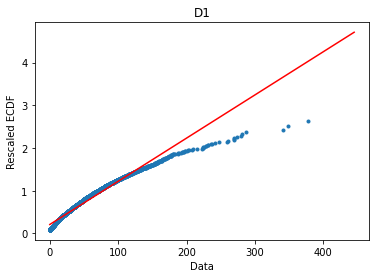

The parameters if D2 were lognormal are:
[ 0.67019807 23.98788164]


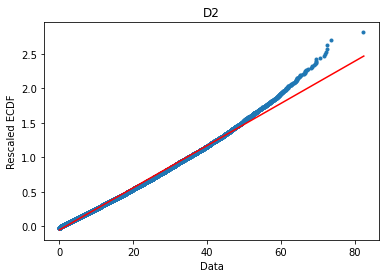

The parameters if D3 were lognormal are:
[ 0.03898662 29.58272712]


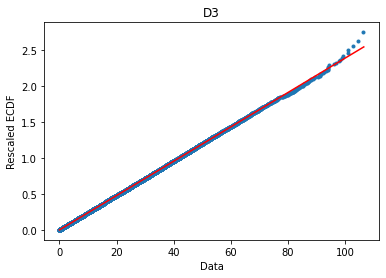

The parameters if D4 were lognormal are:
[-4.97786453 44.03606917]


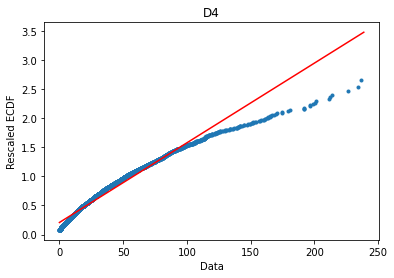

The parameters if D5 were lognormal are:
[ 1.09140292 36.23766542]


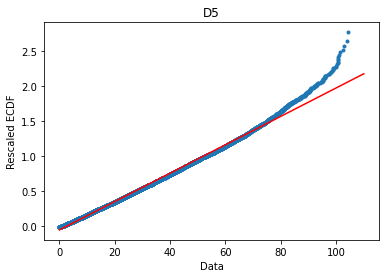

In [7]:
#The easiest to test is lognormal since it is easily transformed
#into normal (just take a log) and we have code from class 
#on how to estimate parameters for truncated normal pdf
#
def Lprobplot_analysis(x,STR):
    #It helps to compute the number of data points first
    N=np.size(x)
    #Also the threshold is:
    t=0
    #And now the log likelihood for pdf truncated at 0
    #I can use bounded minimization to avoid issues with 
    #log of negative number but it is easier to just
    #enforce sigma>0 by taking absolute value
    tG = lambda p: N*np.log(2/np.pi)/2+N*np.log(np.abs(p[1]))+\
                   N*(1-SciSpec.erf((t-p[0])/(np.abs(p[1])*np.sqrt(2))))+\
                   np.sum((np.power(x-p[0],2))/(2*p[1]*p[1]))
    #Estimate the parameters (here mu and sigma)
    #0 and 100 are some random starting guesses
    P=SciOpt.fmin(tG,np.array([0, 100]),disp=False);
    print('The parameters if ' + STR + ' were lognormal are:')
    print(P)
    #OK, now that we know the parameters roughly, we can estimate
    #the number of points that were truncated...
    #find the fraction below 1 relative to above 1
    left=SciStat.norm.cdf(0,P[0],P[1])
    fract=left/(1-left)
    #and find how many numbers were truncated
    #from how many numbers are left
    numTR=int(fract*N); Ntot=N+numTR
    #Now probplot it and see if it looks linear 
    #I choose to do this one by hand
    #first we calculate ECDF
    ecdfX=np.sort(x)
    ecdfY=np.linspace(numTR+1,Ntot,N)/Ntot
    #Now we rescale things to generate normal probplot
    probplotX=ecdfX
    probplotY=SciSpec.erfinv(2*ecdfY-1)
    #plot the result
    plt.plot(probplotX,probplotY,'.')
    #fit the data to a straight line
    #note that we exclude the zeros we prepended
    fitP=np.polyfit(probplotX[:-5],probplotY[:-5],1)
    #plot the line fit
    plt.plot(probplotX,np.polyval(fitP,probplotX),'r')
    #give it proper xlabel, ylabel, and title
    plt.xlabel('Data')
    plt.ylabel('Rescaled ECDF')
    plt.title(STR)
    plt.show()
#
Lprobplot_analysis(np.log(d1),'D1')
Lprobplot_analysis(np.log(d2),'D2')
Lprobplot_analysis(np.log(d3),'D3')
Lprobplot_analysis(np.log(d4),'D4')
Lprobplot_analysis(np.log(d5),'D5')
#probplot for dist{1} curves down
#probplot for dist{2} curves up
#probplot for dist{3} is linear
#probplot for dist{4} curves down
#probplot for dist{5} curves up
#
#Conclusion #1: dist{3} is lognormal
#Conclusion #2: dist{1} and dist{4} are not but they look similar? Maybe?
#Conclusion #3: dist{2} and dist{5} are not but they look similar? Maybe?

The number of truncated points is 7816


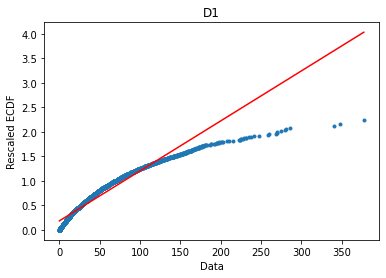

The number of truncated points is 25310


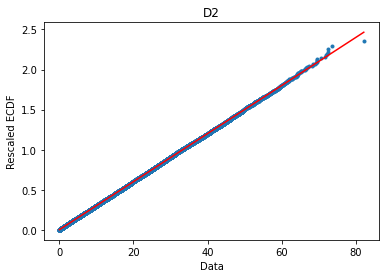

<ipython-input-14-42572482cf12>:9: RuntimeWarning: invalid value encountered in log
  N*p[0]*np.log(p[1])-\
<ipython-input-14-42572482cf12>:11: RuntimeWarning: invalid value encountered in power
  np.sum(np.power(x/p[1],p[0]))+  \
<ipython-input-14-42572482cf12>:12: RuntimeWarning: invalid value encountered in power
  N*(-np.power(t/p[1],p[0]))
<ipython-input-14-42572482cf12>:8: RuntimeWarning: invalid value encountered in log
  tW = lambda p: -N*np.log(p[0])+\


The number of truncated points is 9240


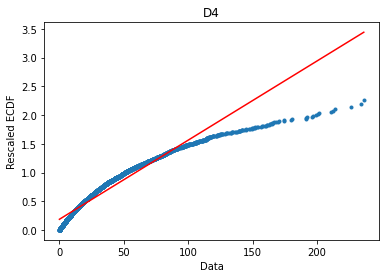

The number of truncated points is 18987


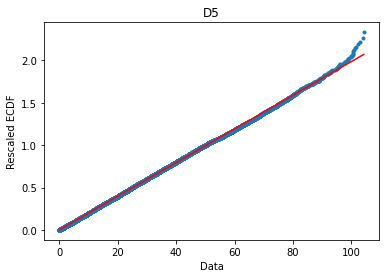

In [ ]:
#Next up is weibull since we probplotted it in class
def Wprobplot_analysis(x,STR):
    #It helps to compute the number of data points first
    N=np.size(x)
    #Also the threshold is:
    t=1
    #And now the log likelihood for pdf truncated at t
    tW = lambda p: -N*np.log(p[0])+\
         N*p[0]*np.log(p[1])-\
         (p[0]-1)*np.sum(np.log(x))+\
         np.sum(np.power(x/p[1],p[0]))+  \
         N*(-np.power(t/p[1],p[0]))
    #Estimate the parameters (here K and lambda)
    #It helps to do a quick eye-ball using the fact that
    #log(Weibull) is Gumbel distribution and since log is
    #increasing function, left truncated Weibull transforms
    #into left truncated Gumbel. One look at standard Gumbel
    #plot and you can tell that k is of order 0.01
    #and lambda is likely around 1.
    P=SciOpt.minimize(tW,np.array([1e-2, 1]),\
                      method='L-BFGS-B');
    #OK, now that we know the parameters roughly, we can estimate
    #the number of points that were truncated...
    #find the fraction below 1 relative to above 1
    left=1-np.exp(-np.power(t/(P.x[1]),P.x[0]))
    fract=left/(1-left)
    #and find how many numbers were truncated
    #from how many numbers are left
    numTR=int(fract*N); Ntot=N+numTR
    print('The number of truncated points is ' + str(numTR))
    #Now probplot it and see if it looks linear 
    #I choose to do this one by hand
    #first we calculate ECDF
    ecdfX=np.sort(x)
    ecdfY=np.linspace(numTR+1,Ntot,N)/Ntot
    #Now we rescale things to generate Weibull probplot
    probplotX=np.log(ecdfX[:-1])
    probplotY=np.log(-np.log(1-ecdfY[:-1]))
    #plot the result
    plt.plot(probplotX,probplotY,'.')
    #fit the data to a straight line
    #note that we exclude the zeros we prepended
    fitP=np.polyfit(probplotX[:-5],probplotY[:-5],1)
    #plot the line fit
    plt.plot(probplotX,np.polyval(fitP,probplotX),'r')
    #give it proper xlabel, ylabel, and title
    plt.xlabel('Data')
    plt.ylabel('Rescaled ECDF')
    plt.title(STR)
    plt.show()
#
Wprobplot_analysis(d1,'D1')
Wprobplot_analysis(d2,'D2')
Wprobplot_analysis(d4,'D4')
Wprobplot_analysis(d5,'D5')
#probplot for dist{2} is linear
#probplot for dist{5} is linear
#
#Conclusion #1: dist{3} is lognormal
#Conclusion #2: dist{1} and dist{4} remain unidentified
#Conclusion #3: dist{2} and dist{5} are Weibull 

The parameter ksi if D1 were Pareto is:
37.18691612608218
The number of truncated points is 527


<ipython-input-20-f71e26f014fb>:12: RuntimeWarning: invalid value encountered in log
  (1+1/p[1])*np.sum(np.log(1+p[1]*(x-p[2])/p[0]))- \
<ipython-input-20-f71e26f014fb>:13: RuntimeWarning: invalid value encountered in log
  (N/p[1])*np.log(1+p[1]*(t-p[2])/p[0])


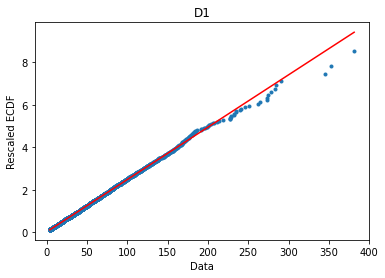

The parameter ksi if D4 were Pareto is:
29.91638559008236
The number of truncated points is 718


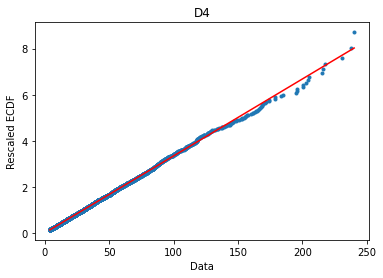

In [ ]:
#Next up is Pareto
def Pprobplot_analysis(x,STR):
    #It helps to compute the number of data points first
    N=np.size(x)
    #Also the threshold is:
    t=1
    #And now the log likelihood for pdf truncated at t
    #p[0] is sigma
    #p[1] is ksi
    #p[2] is mu
    tP = lambda p: N*np.log(p[0])+                \
         (1+1/p[1])*np.sum(np.log(1+p[1]*(x-p[2])/p[0]))- \
         (N/p[1])*np.log(1+p[1]*(t-p[2])/p[0])
    #Estimate the parameters 
    #Enforce sigma>0
    P=SciOpt.minimize(tP,np.array([1, 1, 0]),\
                      bounds=((1e-15,None),(None,None),(None, None)),\
                      method='L-BFGS-B');
    print('The parameter ksi if ' + STR + ' were Pareto is:')
    print(P.x[1])
    #OK, now that we know the parameters roughly, we can estimate
    #the number of points that were truncated...
    #find the fraction below 1 relative to above 1
    left=1-np.power(1+P.x[1]*(t-P.x[2])/P.x[0],-1/P.x[1])
    fract=left/(1-left)
    #and find how many numbers were truncated
    #from how many numbers are left
    numTR=int(fract*N); Ntot=N+numTR
    print('The number of truncated points is ' + str(numTR))
    #Now probplot it and see if it looks linear 
    #I choose to do this one by hand
    #first we calculate ECDF
    ecdfX=np.sort(x)
    ecdfY=np.linspace(numTR+1,Ntot,N)/Ntot
    #Now we rescale things to generate probplot
    probplotX=np.log(1+P.x[1]*(ecdfX[:-1]-P.x[2])/P.x[0])
    probplotY=-np.log((1-ecdfY[:-1]))
    #plot the result
    plt.plot(probplotX,probplotY,'.')
    #fit the data to a straight line
    #note that we exclude the zeros we prepended
    fitP=np.polyfit(probplotX[:-5],probplotY[:-5],1)
    #plot the line fit
    plt.plot(probplotX,np.polyval(fitP,probplotX),'r')
    #give it proper xlabel, ylabel, and title
    plt.xlabel('Data')
    plt.ylabel('Rescaled ECDF')
    plt.title(STR)
    plt.show()
#
Pprobplot_analysis(d1,'D1')
Pprobplot_analysis(d4,'D4')
#probplot for d1 is linear
#probplot for d4 is linear
#
#Conclusion #1: dist{3} is lognormal
#Conclusion #2: dist{1} and dist{4} are Pareto
#Conclusion #3: dist{2} and dist{5} are Weibull 
#
#Notice that Levy could also give power law tail 
#but only with power -3/2 !!!
#For generalized pareto the tail is exponential
#with power law -1-1/ksi
#In both our fits, ksi>10 so this is very far 
#from a Levy-type tail